The goal of our project is to study and identify the relationships between the initial budget and subsequent imdb user rating, metascore critics rating, box office receipts and the number of nominations and awards.

Stages of the study completed:
- Data collection, data parsing from the imdb website
- Data cleaning, processing and preparation

At this stage, we will analyze the data obtained and try to visualize the results

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import pandas as pd
import plotly.express as px
from collections import Counter

Let's start with the graph below.

In this graph, we see a clear dependence of box office receipts on the initial budget. Films above the red line have box office receipts higher than the budget allocated for their filming.

It is clear from the graph that as the budget increases, so do box office receipts, which in turn are one of the indicators of the film's quality.

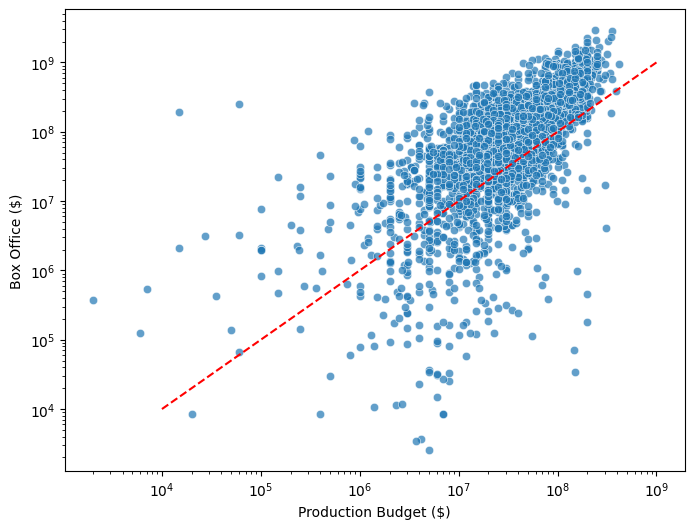

In [2]:
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

budgets = []
box_offices = []

for film in films:
    if film["production_budget"] and film["box_office"]:
        budgets.append(film["production_budget"])
        box_offices.append(film["box_office"])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=budgets, y=box_offices, alpha=0.7)

# Add reference line (budget = box office)
x_vals = np.logspace(4, 9, 100)  # Avoid 0; start from 10^6 to 10^9
plt.plot(x_vals, x_vals, linestyle="--", color="red", label="Break-even line")

plt.xlabel("Production Budget ($)")
plt.ylabel("Box Office ($)")
plt.xscale("log")  # Use scale for better display
plt.yscale("log")
plt.show()

Next, we will build the same dependence but add the IMDB rating and metascore rating to it. Here we can notice 2 things:

1. Despite the fact that the medians of the green and blue groups (with high ratings) are higher than, for example, the indicators of the red or orange group (with low ratings), the dependence of ratings on the budget or box office receipts cannot be called linear.

2. The IMDB rating does not quite correctly show the real quality of the film. In comparing the graphs, we see that the IMDB graph in comparison with the metascore opinion does not have a normal distribution and is concentrated in the region of 6 - 8 points. This indicates that ordinary viewers are not inclined to give too low or too high ratings to films, even if their impressions correspond to them.

In [6]:
# Load data
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

# Prepare data
data = []
for film in films:
    if film["production_budget"] and film["box_office"] and film["imdb"] and film["metascore"]:
        data.append({
            "title": film["title"],
            "budget": film["production_budget"],
            "box_office": film["box_office"],
            "imdb": round(film["imdb"]),
            "metascore": round(film["metascore"] // 10) * 10
        })

df = pd.DataFrame(data)

# Define colors for IMDb-based plot (HEX colors)
def imdb_color(imdb_score):
    if imdb_score < 3.5:
        return "< 3.5"  # Red
    elif imdb_score < 5.5:
        return "< 5.5"  # Orange
    elif imdb_score < 6.5:
        return "< 6.5"  # Yellow
    elif imdb_score < 7.5:
        return "< 7.5"  # DodgerBlue
    else:
        return ">= 7.5"  # Green

df["imdb_color"] = df["imdb"].apply(imdb_color)

# Define colors for Metascore-based plot (HEX colors)
def metascore_color(metascore):
    if metascore < 35:
        return "< 35"  # Red
    elif metascore < 55:
        return "< 55"  # Orange
    elif metascore < 65:
        return "< 65"  # Yellow
    elif metascore < 75:
        return "< 75"  # DodgerBlue
    else:
        return ">= 75"  # Green

df["metascore_color"] = df["metascore"].apply(metascore_color)

# --- IMDb-based dot plot ---
fig1 = px.scatter(
    df, x="budget", y="box_office",
    size="imdb", color="imdb_color",
    hover_name="title",
    marginal_x="rug",
    marginal_y="rug",
    title="Box Office vs Production Budget (IMDb-based)",
    log_x=True, log_y=True,
    color_discrete_map={
        "< 3.5": "Red",
        "< 5.5": "Orange",
        "< 6.5": "Yellow",
        "< 7.5": "Blue",
        ">= 7.5": "Green"
    }
)
fig1.update_layout(height=800)
fig1.show()

# --- Metascore-based dot plot ---
fig2 = px.scatter(
    df, x="budget", y="box_office",
    size="metascore", color="metascore_color",
    hover_name="title",
    marginal_x="rug",
    marginal_y="rug",
    title="Box Office vs Production Budget (Metascore-based)",
    log_x=True, log_y=True,
    color_discrete_map={
        "< 35": "Red",
        "< 55": "Orange",
        "< 65": "Yellow",
        "< 75": "Blue",
        ">= 75": "Green"
    }
)
fig2.update_layout(height=800)
fig2.show()


To confirm conclusion number 2 from the previous graph, we will construct a rating distribution diagram in different genres. By comparing the graphs for IMDB and metascore, we confirm our hypothesis and come to the conclusion that it is not entirely correct to rely on the imdb rating to determine the quality of a film.

In [7]:
with open("data/films_metascore_unknown.json", "r", encoding="utf-8") as f:
    films = json.load(f)

genre_counter = Counter()
for film in films:
    if "genres" in film:
        genre_counter.update(film["genres"])

top_10_genres = {genre for genre, _ in genre_counter.most_common(10)}

data = []
for film in films:
    if "genres" in film and film["imdb"] and film["metascore"]:
        imdb_rounded = round(film["imdb"] * 2) / 2
        metascore_rounded = round(film["metascore"] / 5) * 5
        for genre in film["genres"]:
            if genre in top_10_genres:
                data.append({"genre": genre, "imdb": imdb_rounded, "metascore": metascore_rounded})

df = pd.DataFrame(data)

fig1 = px.histogram(df,
                    x="imdb",
                    animation_frame="genre",
                    title="IMDb rating distribution by genre",
                    labels={"imdb": "IMDb", "genre": "Genre"},
                    template="plotly_dark",
                    color_discrete_sequence=["lightblue"])

fig1.update_layout(xaxis_title="IMDb", yaxis_title="Number of films", title_font_size=20, font=dict(size=14))
fig1.show()

fig2 = px.histogram(df,
                    x="metascore",
                    animation_frame="genre",
                    title="Metascore distribution by genre",
                    labels={"metascore": "Metascore", "genre": "Genre"},
                    template="plotly_dark",
                    color_discrete_sequence=["orange"])

fig2.update_layout(xaxis_title="Metascore", yaxis_title="Number of films", title_font_size=20, font=dict(size=14))
fig2.show()


This graph shows the relationship between IMDb rating, Metascore, and the number of award nominations for movies in the database

The color of the dot reflects the financial success of the movie, comparing box_office and budget:

🔴 Red - the movie did not recoup its budget (box_office < budget).

🟠 Orange - the movie recouped, but not more than 2 times (budget ≤ box_office < 2 * budget).

🟢 Green - the movie collected more than 2 times its budget (box_office ≥ 2 * budget).

From the graph we can see that:
- Since the dots lie along the diagonal, it means that the audience and critics' ratings are correlated, but the scattered nature of the graph shows that this correlation is weak.
- Movies with a large number of nominations have a high rating, but there is no inverse relationship. This dependence is also weak
- The greatest number of nominations are for films with high profitability. Unlike the rating, profitability shows the success of a film almost linearly. Films with small box office receipts receive fewer awards.

In [8]:
with open("data/films_all_known.json", "r", encoding="utf-8") as f:
    films = json.load(f)

data = []
for film in films:
    if film["imdb"] and film["metascore"] and film["num_of_nominations"] and film["production_budget"] and film["box_office"]:
        budget = film["production_budget"]
        box_office = film["box_office"]

        if box_office < budget:
            color = "1. Box Office < Budget"
        elif budget <= box_office < 2 * budget:
            color = "2. Box Office ~ Budget (x2)"
        else:
            color = "3. Box Office >> Budget (x2+)"

        data.append({
            "title": film["title"],
            "imdb": film["imdb"],
            "metascore": film["metascore"],
            "num_of_nominations": film["num_of_nominations"],
            "color": color
        })

df = pd.DataFrame(data)

fig = px.scatter_matrix(df,
                        dimensions=["imdb", "metascore", "num_of_nominations"],
                        color="color",
                        title="Scatter Matrix: IMDb, Metascore, Nominations",
                        color_discrete_map={
                            "1. Box Office < Budget": "red",
                            "2. Box Office ~ Budget (x2)": "orange",
                            "3. Box Office >> Budget (x2+)": "green"
                        }
                       )

fig.show()


The next stage: studying the obtained results, explaining the found relationships based on additional parameters. Based on the results of the passed stage, we assume the possible influence of the cast or other additional criteria on the results. Therefore, we set ourselves the goal of testing this hypothesis